<a href="https://colab.research.google.com/github/Mannat5649144/DataScience-GenAI-Submissions-/blob/main/Week%204_4_01_Decision_Trees_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 4.01 Decision Trees

Following up on our logistic regression example, we will also run an equivalent using _decision trees_.

We'll begin using the inbuilt dataset from scikit-learn we used previously. The dataset is for predicting the presence of breast cancer or not. You can get more details here: [https://scikit-learn.org/1.5/datasets/toy_dataset.html](https://scikit-learn.org/1.5/datasets/toy_dataset.html). The code is the same as in the previous example.

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# import the data
data = load_breast_cancer()

# create a DataFrame of features
x_values = pd.DataFrame(data.data, columns=data.feature_names)

from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=data.feature_names)

# create y value
y_value = pd.DataFrame(data.target, columns=['class'])
y_value = np.ravel(y_value)

## Train-Test split
As before, our next step will be to split the data:

In [2]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=1984, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(455, 30)
(114, 30)
(455,)
(114,)


Our code is basically the same as before except with an extra parameter ("stratify=y_value"). This part means we make sure there is a propotionate number of each class in our training data. We want to avoid having minimal examples of one of the classes to learn from (as the split is otherwise fully random).

We can confirm this has worked by looking at the size of our different datasets:


*   `X_train` (the $x$ values we use for training) is 455 rows and 30 columns;
*   `X_test` (the $x$ values we use for testing) is 114 rows and 30 columns;
*   `Y_train` (the $Y$ values we use for training) is 455 rows and a single column;
*   `Y_test` (the $Y$ values we use for testing) is 114 rows and a single columns. All seems to be correct!

## Decision Trees
We'll begin with a standard decision tree model WITHOUT adjusting for any hyperparameters. We first need to specify the model:

In [3]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

As before, this is the unfitted/untrained algorithm. Let's make a model:

In [4]:
DTC_model = DTC_algo.fit(X_train, Y_train)
DTC_model

DecisionTreeClassifier()

But how does it perform? I'll give you a metric for free, but you will then have to create some more:

In [5]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.92


We have strong performance ... 90% accuracy. However, not as good as Logistic Regression. Let's look at the confusion matrix:

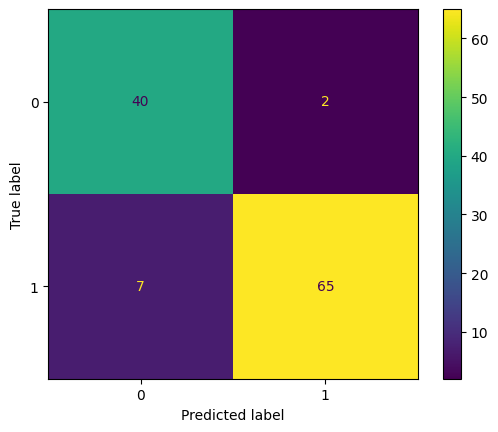

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(Y_test, predict)

We can also extract the precision, recall and F1 score:

In [7]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.92
Micro-averaged Recall: 0.92
Micro-averaged F1-score: 0.92


Macro-averaged Precision: 0.91
Macro-averaged Recall: 0.93
Macro-averaged F1-score: 0.92


We can also see our tree:

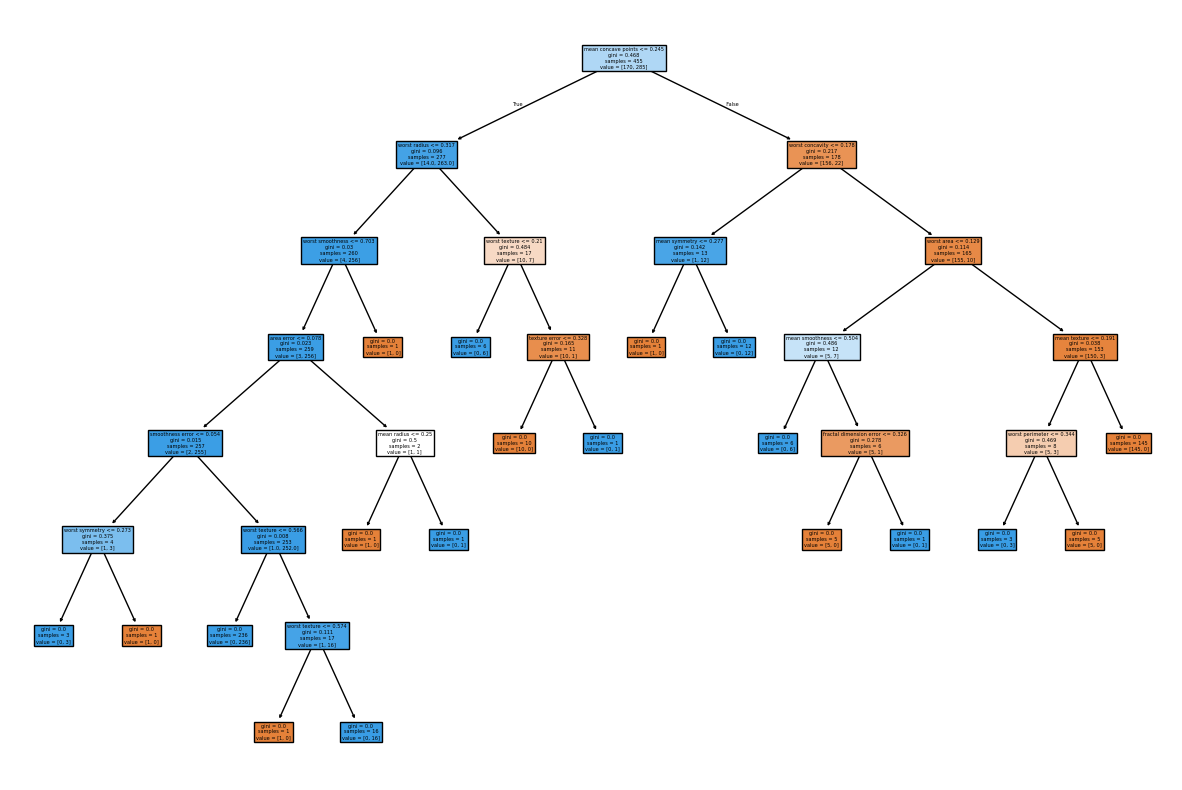

In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

We can see it has built a fairly large tree ... maybe it has overfit? Perhaps regularisation will help ...

We can search our hyperparameters and see what would be best:

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)


Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7}


Now we can train the model again, but using these hyperparameters:

In [10]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, Y_train)

And now we can predict again:

In [11]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.96


Accuracy is better. However, we tuned for F1 macro ... maybe this will be better too:

Micro-averaged Precision: 0.96
Micro-averaged Recall: 0.96
Micro-averaged F1-score: 0.96


Macro-averaged Precision: 0.96
Macro-averaged Recall: 0.97
Macro-averaged F1-score: 0.96




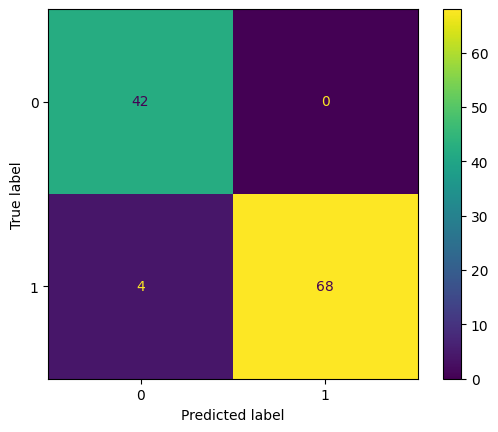

In [12]:
# create a confusion matrix
CM.from_predictions(Y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

F1 score is 3 points higher! Let's also check the tree:

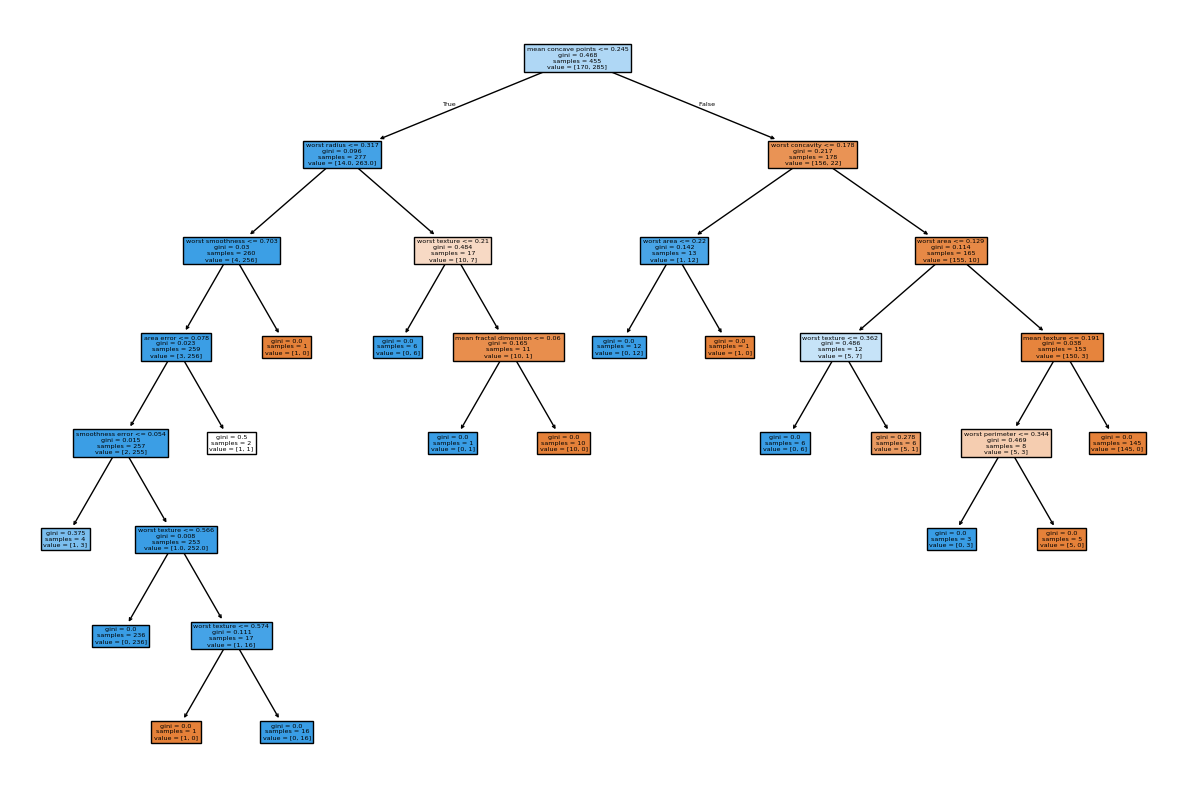

In [13]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

A much smaller tree so likely to be less prone to overfitting!

### TASK
Given that this is a medical domain, possibly a better metric to optimise against would be _recall_. Reoptimise the model according to _macro recall_ and evaluate the results.





In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, recall_score

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(3, 9)),  # Example: check depths from 3 to 8
    'min_samples_split': list(range(3, 9)), # Example: check splits from 3 to 8
    'min_samples_leaf': list(range(1, 5)),  # Example: check leaves from 1 to 4
    'max_features': ['sqrt', 'log2', None]
}

# Initialize GridSearchCV
grid_recall = GridSearchCV(DTC(), param_grid, cv=5, scoring='recall_macro', verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_recall.fit(X_train, Y_train)

print("Best parameters found:")
print(grid_recall.best_params_)
print("\n")

# Extract the best estimator
best_dt_recall = grid_recall.best_estimator_

# Make predictions on the test set
y_pred_recall = best_dt_recall.predict(X_test)

# Evaluate the model
macro_recall_score = recall_score(Y_test, y_pred_recall, average='macro')

print(f"Macro Recall on Test Set: {round(macro_recall_score, 2)}")
print("\n")
print("Classification Report on Test Set:")
print(classification_report(Y_test, y_pred_recall))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found:
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 5}


Macro Recall on Test Set: 0.95


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        42
           1       0.97      0.94      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



I retuned the decision tree using GridSearchCV with scoring='recall_macro', which optimises the model to maximise recall averaged across both classes. This is appropriate in a medical context, where missing positive cases is costly.
The best hyperparameters found were criterion='entropy', max_depth=8, max_features='log2', min_samples_leaf=3, and min_samples_split=5.
On the test set the macro recall is 0.95, meaning that, on average across both classes, 95% of true cases are correctly identified. Class 0 has recall 0.95 and class 1 has recall 0.94, so performance is strong and fairly balanced between classes. Accuracy is also 0.95, indicating that focusing on recall did not sacrifice overall predictive performance.


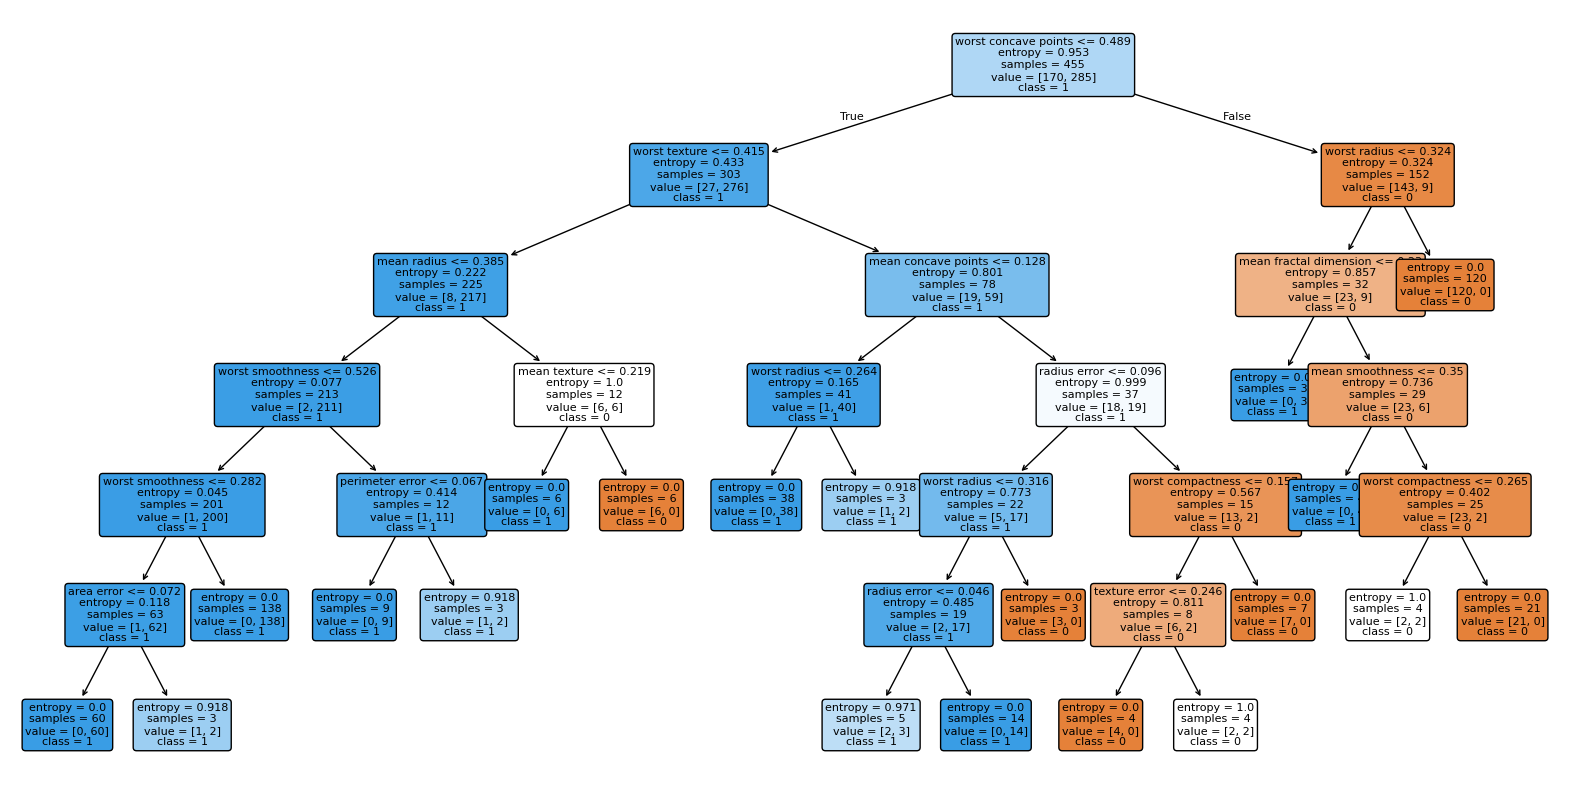

In [16]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
tree.plot_tree(
    best_dt_recall,
    feature_names=X_train.columns,
    class_names=[str(c) for c in best_dt_recall.classes_],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()

The root split of the tree is on worst concave points ≤ 0.489, indicating this feature provides the largest reduction in impurity and is therefore the most important first decision for distinguishing between the two classes in this medical dataset. Nodes on the left side of the tree (blue) mostly predict class 1, while nodes on the right side (orange) mostly predict class 0, showing how different combinations of “worst” shape/size measurements drive the classification. Many terminal nodes are pure or nearly pure (entropy close to 0 and very skewed class counts), which is consistent with the strong macro‑recall performance of 0.95 achieved by this model on the test set.